# 02. Neural Network Classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [275]:
import sklearn  # type: ignore
from sklearn.datasets import make_circles # type: ignore

sklearn.show_versions()


System:
    python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
executable: c:\Users\bolth\anaconda3\python.exe
   machine: Windows-11-10.0.22635-SP0

Python dependencies:
      sklearn: 1.5.1
          pip: 24.0
   setuptools: 69.5.1
        numpy: 1.26.4
        scipy: 1.14.0
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
    num_threads: 12
         prefix: mkl_rt
       filepath: C:\Users\bolth\anaconda3\Library\bin\mkl_rt.2.dll
        version: 2023.1-Product
threading_layer: intel

       user_api: openmp
   internal_api: openmp
    num_threads: 12
         prefix: vcomp
       filepath: C:\Users\bolth\anaconda3\vcomp140.dll
        version: None

       user_api: openmp
   internal_api: openmp
    num_threads: 16
         prefix: libiomp
       filepath: C:\Users\bolth\anaconda3\Library

In [276]:
# make 1000 samples
n_samples = 1000

# create circles (X for matrix and y for labels)
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [277]:
len(X), len(y)

(1000, 1000)

In [278]:
print(f"First 5 samples of X: \n{X[:5]}")
print(f"First 5 samples of y: \n{y[:5]}")
# the elements of y is binary whereas elements of X is more diverge
# it looks that y is label for X (binary classification)

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
[1 1 1 1 0]


In [279]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [303]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

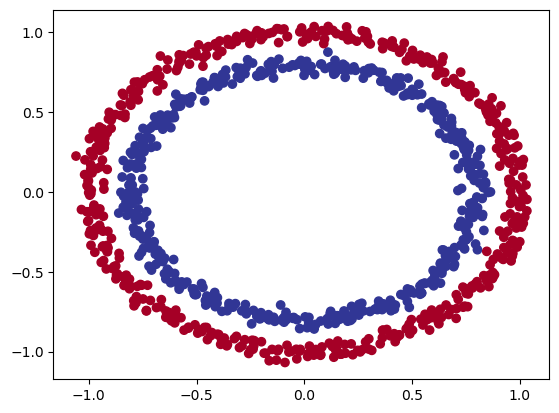

In [280]:
import matplotlib.pyplot as plt 
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred as a toy dataset, a dataset that is small enought to practice the fundamentals.

learn more - https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1 Check input and output shapes

In [281]:
X.shape, y.shape

((1000, 2), (1000,))

In [282]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data intotensor and create train and test splits

In [283]:
import torch 
torch.__version__

'2.4.0'

In [284]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [285]:
# turn data into tensors 
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [286]:
# split data into training and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split # type: ignore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# this is the default order from scikit for random data splitting

In [287]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

The objective is to build a model that can classify the blue and red dots. 

To do so, these are the following steps:
1. Setup device agnostic code so the code will run on an accelarator (GPU)
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [288]:
from torch import nn 

# make device agnostic code 
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Device: {device}")

Device: cuda


In [289]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

There are some few steps to buld the model:

1. Subclasses `nn.Module` 
2. Create two `nn.Linear()` layers that are capable of handling the shapes of the data
3. Define a `forward()` method that outlines the forward pass (forward propagation) of the model
4. Instantiate an instance of the model class and send it to the target `device`

In [290]:
# input features
X_train.shape, X_train.ndim

(torch.Size([800, 2]), 2)

In [291]:
# output feature
y_train.shape, y_train[0], y_train.ndim

(torch.Size([800]), tensor(1.), 1)

In [292]:
# 1. construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layers for handling the shapes for the data (X_train has shape of two)
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (shape of X) and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from prev layer (out_features of layer_1) and output a single feature (same shape as y)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    # 3 define a forward method that outlines (forward propagation)
    def forward(self, x: torch.Tensor):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2
        ## return self.two_linear_layers(x)

# 4. instantiate an instance of the model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

neural network playground - [tensorflow-playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.39974&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

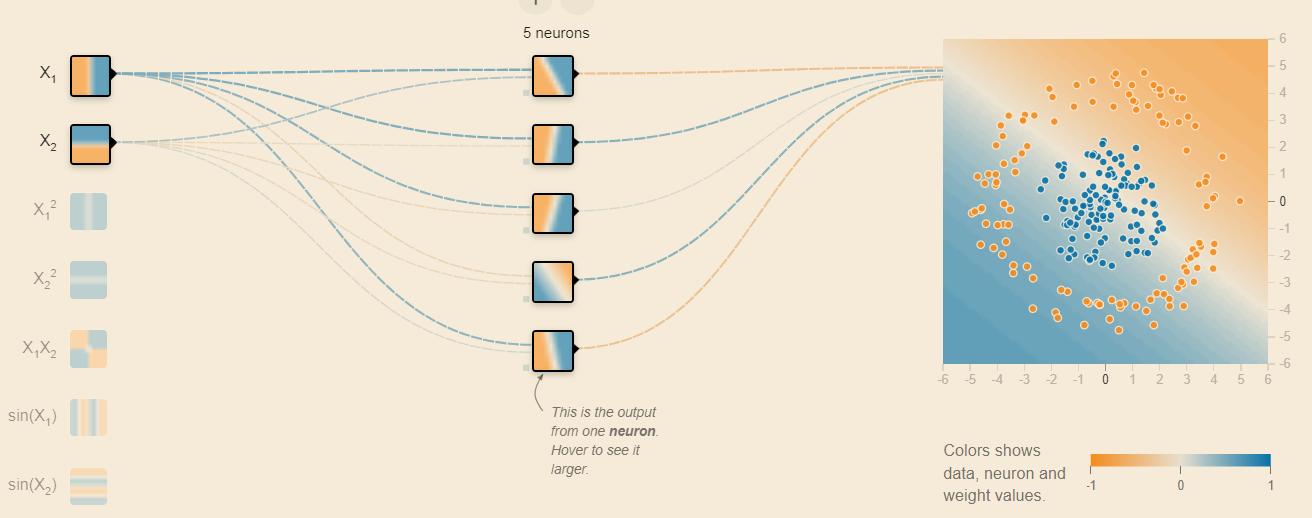


In [293]:
# replicating the model above using nn.Sequential()
model_0_with_sequential = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0_with_sequential

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [294]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.4066, -0.0540],
                      [-0.1409, -0.5361],
                      [-0.0321, -0.6005],
                      [-0.2571,  0.5041],
                      [ 0.2503, -0.0692]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.6986,  0.1493, -0.6361, -0.2863,  0.5469], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1004,  0.0694,  0.2176, -0.3537, -0.3547]], device='cuda:0')),
             ('layer_2.bias', tensor([0.4202], device='cuda:0'))])

### 2.1 Setup loss function and optimizer 
which loss function or optimizer should be used? 
well this is problem specific, you'll figure it out overtime you build machine learning models

For example:
- for regression problem you might want MAE or MSE (mean absolute error or mean squared error). 
- for classification problem, you might want binary cross entropy or categorical cross entropy.

And for optimizers, two of the most common and useful are SGD and Adam, however pytorch has many built-in options.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [295]:
# setup loss function 
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

In [296]:
torch.eq(torch.tensor(data=[[1, 2], [3, 4]]), torch.tensor([[1, 1], [3,1]]))

tensor([[ True, False],
        [ True, False]])

In [297]:
# calculate accurary - out of 100 examples, what percentage does our model get right?
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # eq tells how many is the value of y_pred that equals to y_true
    acc = (correct/len(y_pred)) * 100 
    return acc

## 3. Training the model

1. feed forward 
2. calculate loss
3. optimize zero grad (for efficient computation)
4. loss backward (backprop)
5. optimize step

### 3.1 going from raw logits -> prediction probabilities -> prediction labels

The outputs of our model are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. Sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the ``argmax()``

In [298]:
# view the first 5 outputs (raw logits) of the forward pass on the test data
with torch.inference_mode():   
    y_logits = model_0(X_test.to(device))[:5] # without being passed to any activation function
y_logits

tensor([[-0.1038],
        [-0.1843],
        [ 0.2137],
        [-0.1943],
        [ 0.3831]], device='cuda:0')

In [299]:
# use the sigmoid activation function on the model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4741],
        [0.4541],
        [0.5532],
        [0.4516],
        [0.5946]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
- `y_pred_probs` >= 0.5, `y=1` (class 1)
- `y_pred_probs` < 0.5, `y=0` (class 0)

In [300]:
# find the predicted labels
torch.round(y_pred_probs), y_test[:5] # now it's apple to apple with the y_test

(tensor([[0.],
         [0.],
         [1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [301]:
y_preds = torch.round(y_pred_probs)

# full expression
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building training and testing loop

In [302]:
# set the epochs
epochs = 1000

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train.to(device))
    acc = accuracy(y_true=y_train.to(device), y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test.to(device)).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test.to(device))
        test_acc = accuracy(y_true=y_test.to(device), y_pred=test_preds)
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, accuracy: {acc:.2f} | testing loss: {test_loss:.5f}, test accuracy: {test_acc:.2f} ")

epoch: 0 | Loss: 0.70259, accuracy: 51.25 | testing loss: 0.69342, test accuracy: 53.50 
epoch: 100 | Loss: 0.70217, accuracy: 51.00 | testing loss: 0.69317, test accuracy: 54.00 
epoch: 200 | Loss: 0.70179, accuracy: 51.12 | testing loss: 0.69295, test accuracy: 53.50 
epoch: 300 | Loss: 0.70143, accuracy: 50.88 | testing loss: 0.69276, test accuracy: 53.50 
epoch: 400 | Loss: 0.70110, accuracy: 51.00 | testing loss: 0.69258, test accuracy: 53.50 
epoch: 500 | Loss: 0.70079, accuracy: 50.75 | testing loss: 0.69243, test accuracy: 52.50 
epoch: 600 | Loss: 0.70051, accuracy: 50.62 | testing loss: 0.69229, test accuracy: 51.50 
epoch: 700 | Loss: 0.70024, accuracy: 50.75 | testing loss: 0.69217, test accuracy: 53.00 
epoch: 800 | Loss: 0.69999, accuracy: 50.62 | testing loss: 0.69206, test accuracy: 53.00 
epoch: 900 | Loss: 0.69976, accuracy: 50.62 | testing loss: 0.69196, test accuracy: 53.00 


## 4. Make predictions and evaluate the model

From the metrics it looks like the model isn't learning anything.
So, to inspect it let's make some predictions and make them visual

In [318]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists!")
else:
    print("downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

downloading helper_functions.py


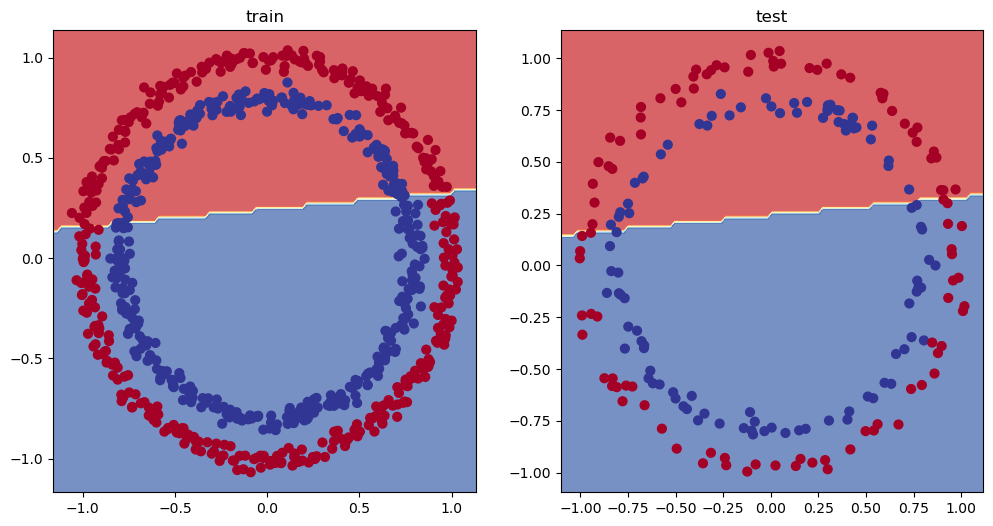

In [319]:
from helper_functions import plot_decision_boundary, plot_predictions

# plot decision boundary of the model 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)